## Current Python Version

Ensure the python version running in the jupyter kernel is the same as expected

In [1]:
# from platform import python_version

# print(python_version())


The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


List installed packages, should match the ones in the pipfile (and their dependencies)

In [2]:
# pip list

## Internal Module Imports
Code required to enable project's internally defined modulos into the jupyter notebook environment

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
# from electricity import ElectricalSystem, Load, Generator
from dto import (
    COST_PRESETS, 
    ElectricalSystemSpecs, 
    EpsilonSpecs,
    GeneratorSpecs, 
    LoadSpecs, 
    NodeStatePower, 
    SystemHistory, 
    )
    
from learning import ModelTrainer, ModelTester, LearningParams

/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 

Determine the experiment params

In [5]:
from dto import EpsilonSpecs, ElectricalConstants
import math

LearningParams(
    gamma=0.9,   # Gamma (Discount)
    tau=0.001, # Tau
    epsilonSpecs = EpsilonSpecs( # Epsilon explore/exploit control
        thresholdProgress = 0.6, # % of steps where decay change should happen
        thresholdValue = 0.5, # Value at which decay change would happen
        finalValue = 0.0001, # Value at the end of the experiment
    ),
    numEpisodes=5000, # Number of learning episodes to run
    maxSteps=100,   # Number of steps per learning episode
    bufferSize=500, # Experience Buffer Size
    traceLength=20,     # Number of steps each sampled episode should contain
    batchSize=10,     # Number of episodes sampled from experience buffer
    updateInterval=4, # Run update cycle every N steps
    electricalSystemSpecs = ElectricalSystemSpecs(
        loads=[LoadSpecs(id_="L1", basePower=3.0, noiseLevel=0.01)],
        generators=[
            GeneratorSpecs(id_="G1", basePower=1.0, costProfile=COST_PRESETS.COAL_2, minPower=0.5, maxPower=3.0, noiseLevel=0.005),
            GeneratorSpecs(id_="G2", basePower=1.0, costProfile=COST_PRESETS.OIL_2, minPower=0.5, maxPower=3.0, noiseLevel=0.005),
            GeneratorSpecs(id_="G3", basePower=1.0, costProfile=COST_PRESETS.OIL_ALTERNATE_2, minPower=0.5, maxPower=3.0, noiseLevel=0.005),
        ],
        shouldTrackOptimalCost=True,
    ),
    modelName='Pico-3Gens-Cost-5k-PF2-c4-Scaled'
)

# Droop = +infinity essentially remove the droop component from the power update equation. System reacts as if droop is disabled
# ElectricalConstants().droop = math.inf

LearningParams(electricalSystemSpecs=ElectricalSystemSpecs(loads=[LoadSpecs(id_='L1', basePower=3.0, noiseLevel=0.01)], generators=[GeneratorSpecs(id_='G1', basePower=1.0, costProfile=CostProfile(alpha=510.0, beta=7.7, gamma=0.00142), minPower=0.5, maxPower=3.0, noiseLevel=0.005), GeneratorSpecs(id_='G2', basePower=1.0, costProfile=CostProfile(alpha=310.0, beta=7.85, gamma=0.00194), minPower=0.5, maxPower=3.0, noiseLevel=0.005), GeneratorSpecs(id_='G3', basePower=1.0, costProfile=CostProfile(alpha=78.0, beta=7.55, gamma=0.00482), minPower=0.5, maxPower=3.0, noiseLevel=0.005)], shouldTrackOptimalCost=True), gamma=0.9, tau=0.001, epsilonSpecs=EpsilonSpecs(thresholdProgress=0.6, thresholdValue=0.5, finalValue=0.0001), numEpisodes=5000, maxSteps=100, bufferSize=500, traceLength=20, batchSize=10, updateInterval=4, nnShape=NeuralNetworkShape(layer_00_ltsm=100, layer_01_mlp_01=1000, layer_02_mlp_02=100, layer_03_mlp_03=50, layer_04_mlp_04=1), explorationNoiseSize=0.4, actionScale=0.1, modelNa

Train Agents

In [6]:
def rewardFn(totalCost, outputDifferential):
#     scaledCost = totalCost/(100000.0) # Scale down cost to levels near the ones found in output differential (e.g. 0.1 */ 0.01)
    minCost = 2073.45
    maxCost = 8564.2
    scaledCost = (totalCost-minCost)/(maxCost-minCost)
    scaledOutputDifferential = outputDifferential*10
    costComponent = 2**(-1*(scaledCost**2))
    outputComponent = 2**(-1*(scaledOutputDifferential**2)*10)
    earnedReward = costComponent*outputComponent
    
#     print(f'Scaled_Cost:{scaledCost} - OutputDiff:{scaledOutputDifferential} - costComponent:{costComponent} - outputComponent:{outputComponent} - reward:{earnedReward}')

    return earnedReward, {'cost': costComponent, 'output': outputComponent, 'total':earnedReward}

In [7]:
from learning.cost import ModelAdapterCost as ModelAdapter
modelAdapter = ModelAdapter(rewardFn=rewardFn)

In [8]:
%%time
allAgents = ModelTrainer(modelAdapter).trainAgents()

W0922 00:53:11.258346 139688654145280 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0922 00:53:11.259194 139688654145280 deprecation.py:323] From /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/learning/actor.py:29: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0922 00:53:11.280970 139688654145280 deprecation.py:323] From /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/learning/actor.py:38: dyna

Training model: Pico-3Gens-Cost-5k-PF2-c4-Scaled - 0% 1% 2% 3% 4% 5% 6% 7% 8% 9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99% 100%
Model saved in path: /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/models/Pico-3Gens-Cost-5k-PF2-c4-Scaled/model
CPU times: user 15h 20min 24s, sys: 2h 47s, total: 17h 21min 11s
Wall time: 8h 9min 26s


In [9]:
STEPS_TO_TEST = 300

# testSpecs = ElectricalSystemSpecs(
#         loads=[LoadSpecs(id_="L1", basePower=3.0, noiseLevel=0.1)],
#         generators=[
#             GeneratorSpecs(id_="G1", basePower=1.5, costProfile=COST_PRESETS.COAL, minPower=0.5, maxPower=2.0, noiseLevel=0.0),
#             GeneratorSpecs(id_="G2", basePower=1.5, costProfile=COST_PRESETS.OIL, minPower=0.5, maxPower=2.0, noiseLevel=0.0),
#         ],
# )
# electricalSystem, rewards = ModelTester.testAgents(testSpecs, LearningParams().modelName, STEPS_TO_TEST)


electricalSystem, rewards = ModelTester(modelAdapter).testAgents(LearningParams().electricalSystemSpecs, LearningParams().modelName, STEPS_TO_TEST)

W0922 09:02:46.447163 139688654145280 deprecation.py:323] From /home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Alternatively, one can plot the data to better inspect the progression

In [10]:
import matplotlib.pyplot as plt
from learning.learning_state import LearningState
from plots import plotAll, plotExperimentRewardProgression

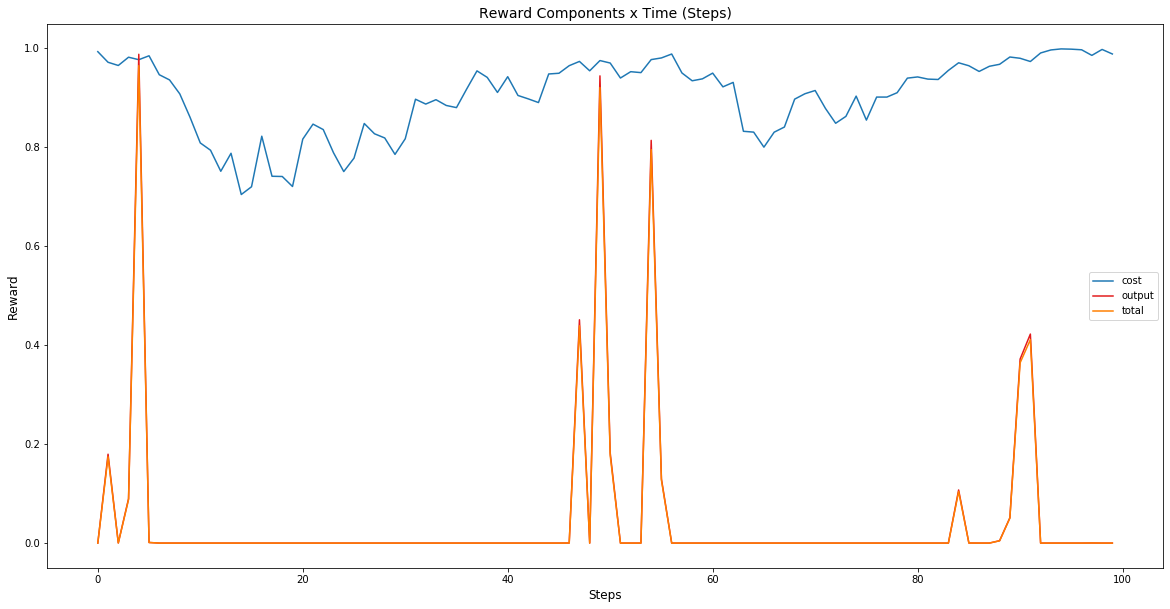

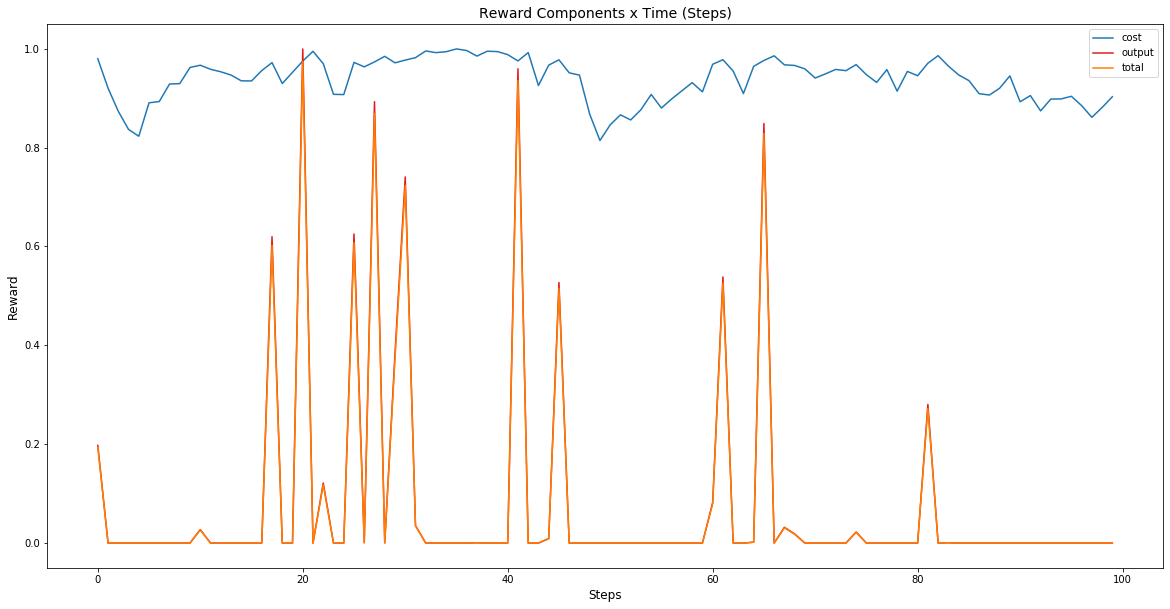

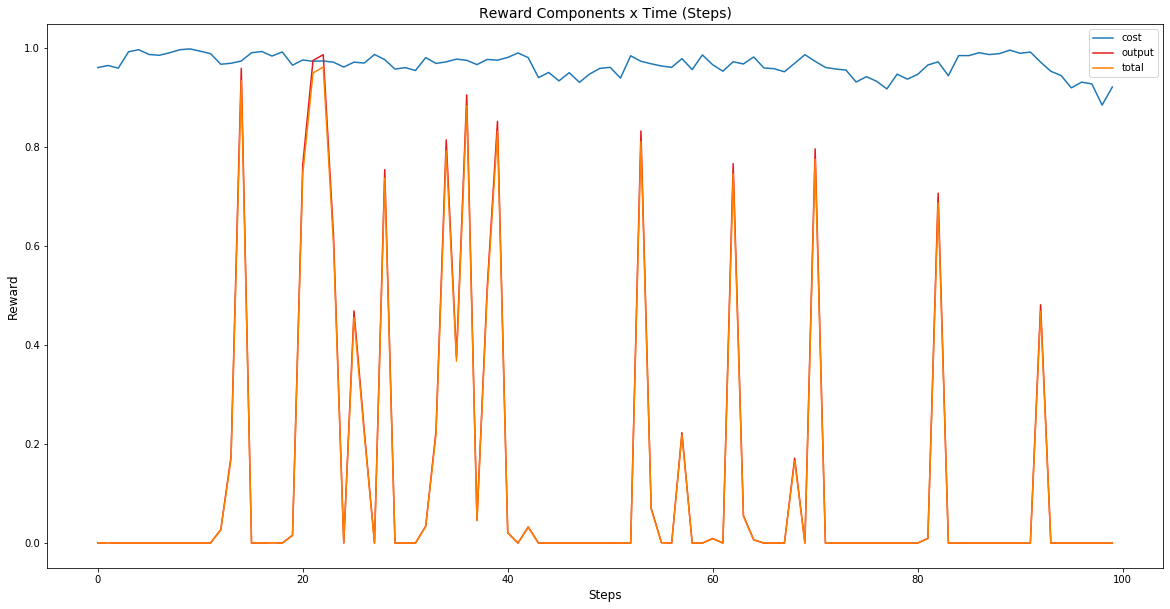

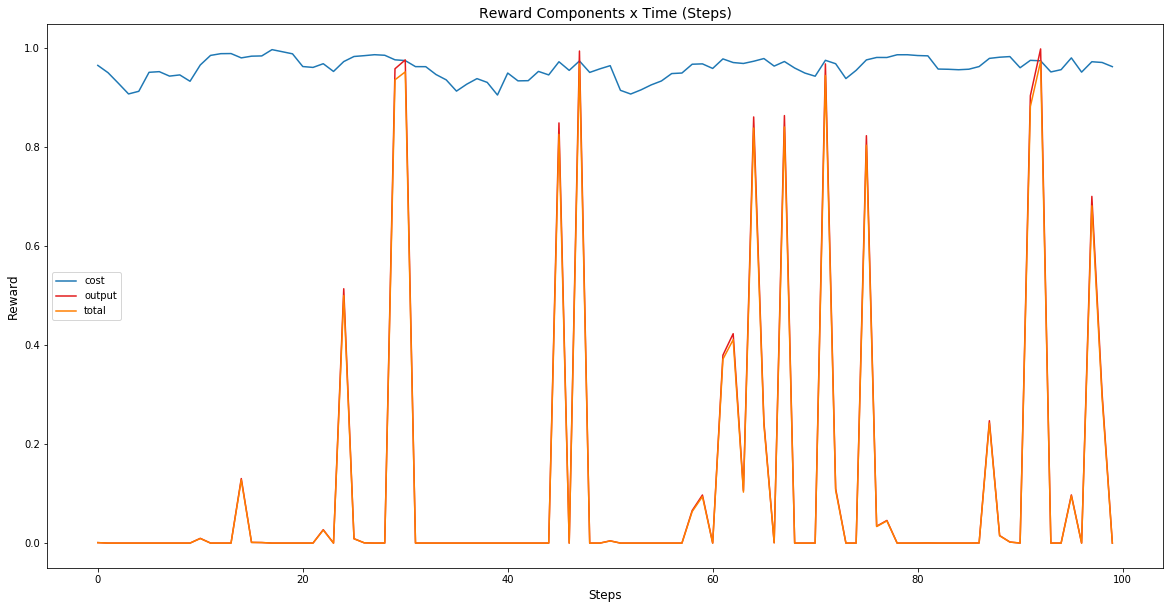

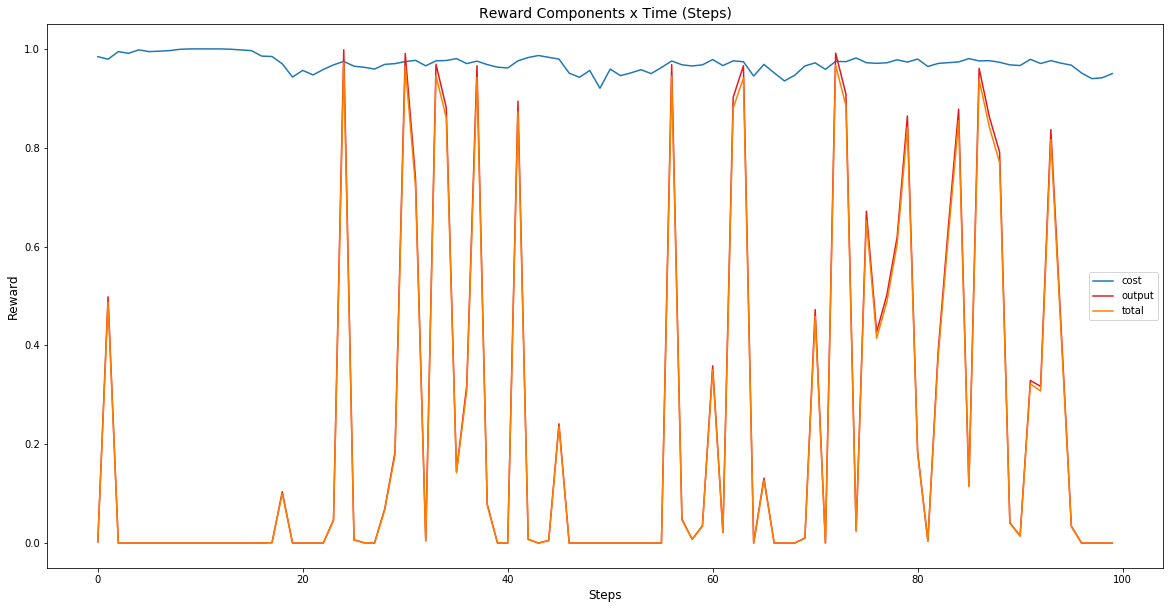

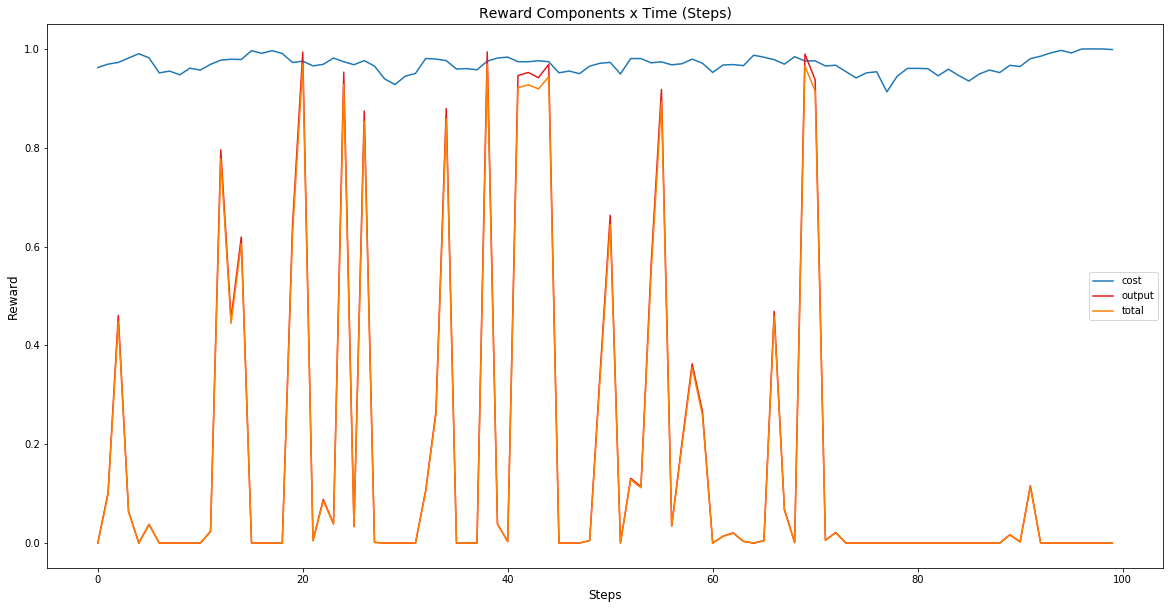

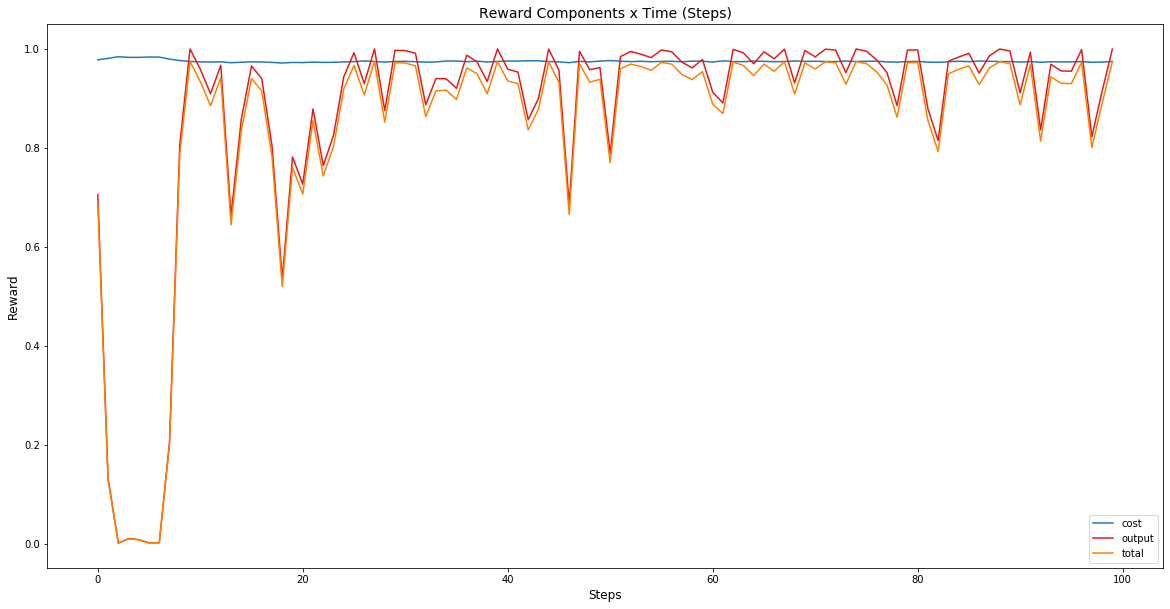

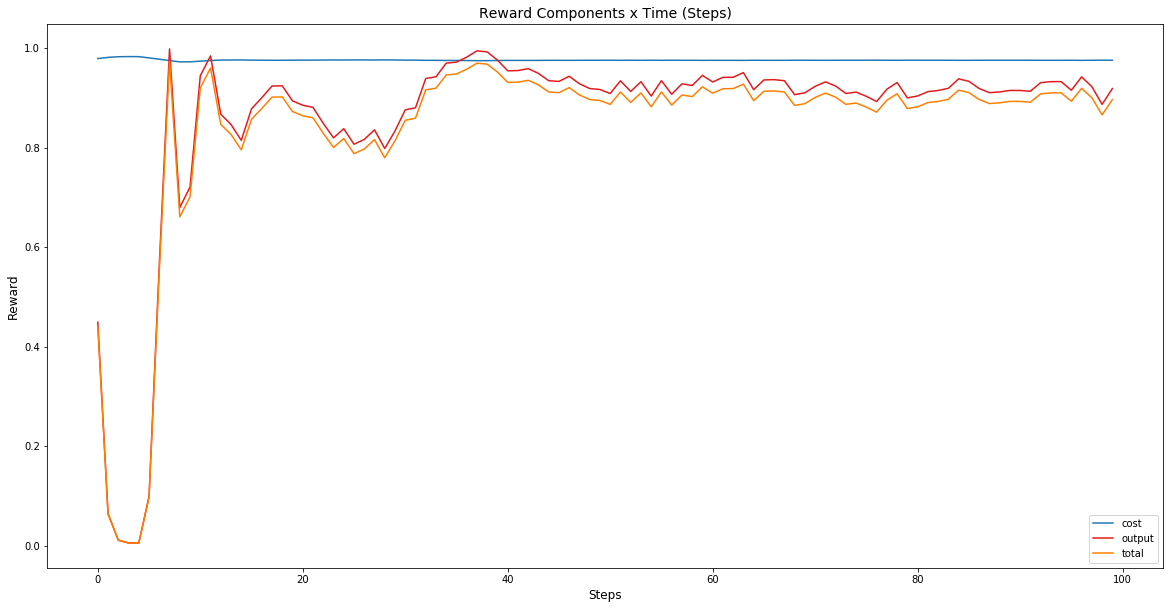

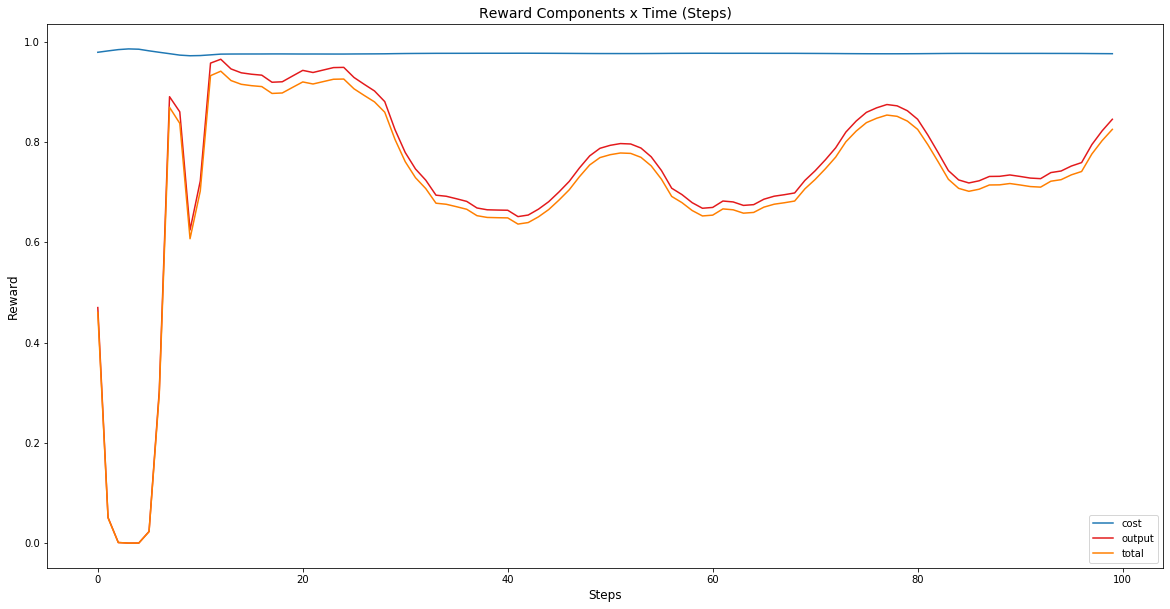

In [11]:
plotExperimentRewardProgression(LearningState().model.allRewards)

Plot the reward progression of the model testing

283.8665396434246

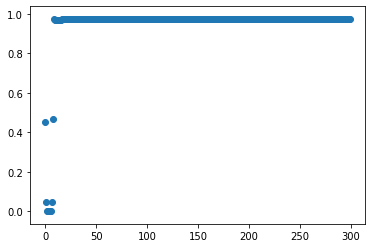

In [12]:
steps = range(STEPS_TO_TEST)
plt.scatter(steps, rewards)
sum(rewards)

Plot all graphs related to the electrical system state during the model testing

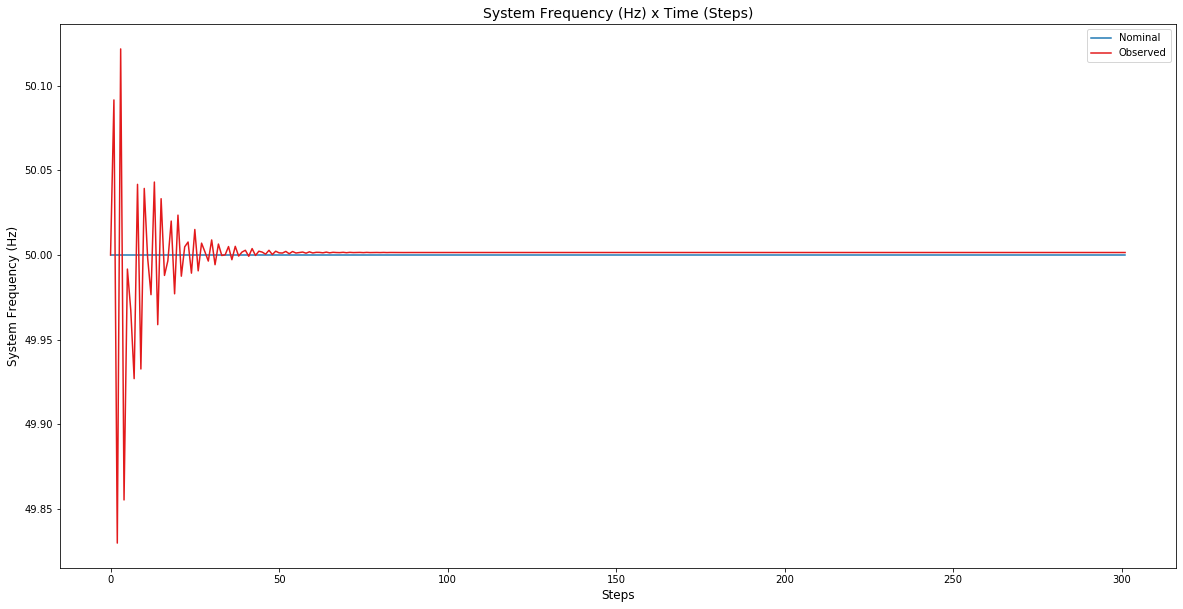

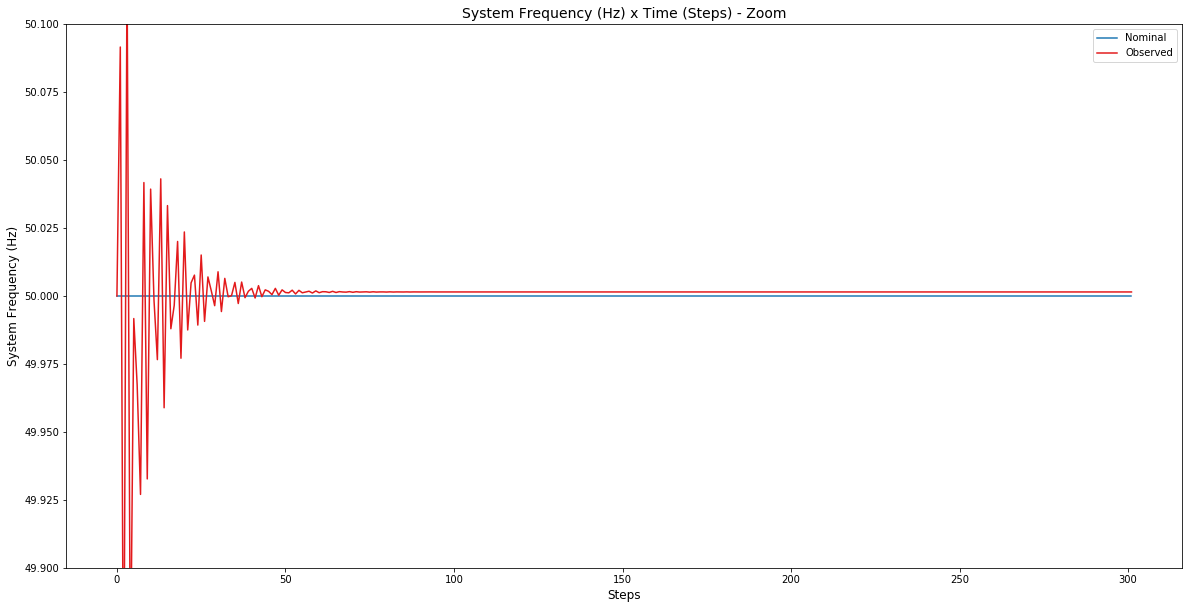

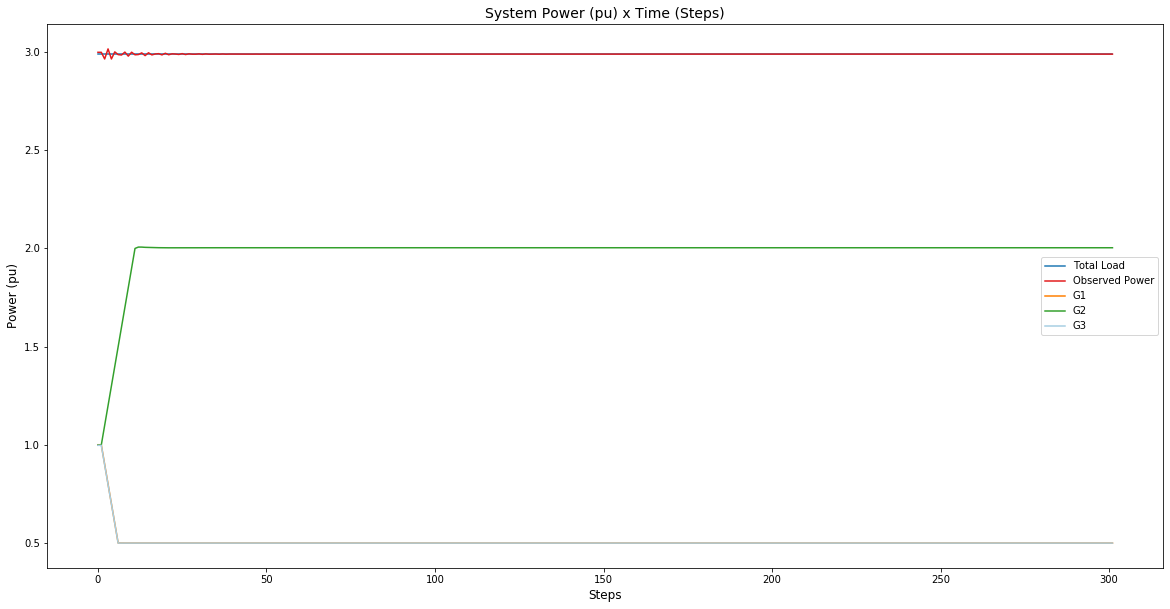

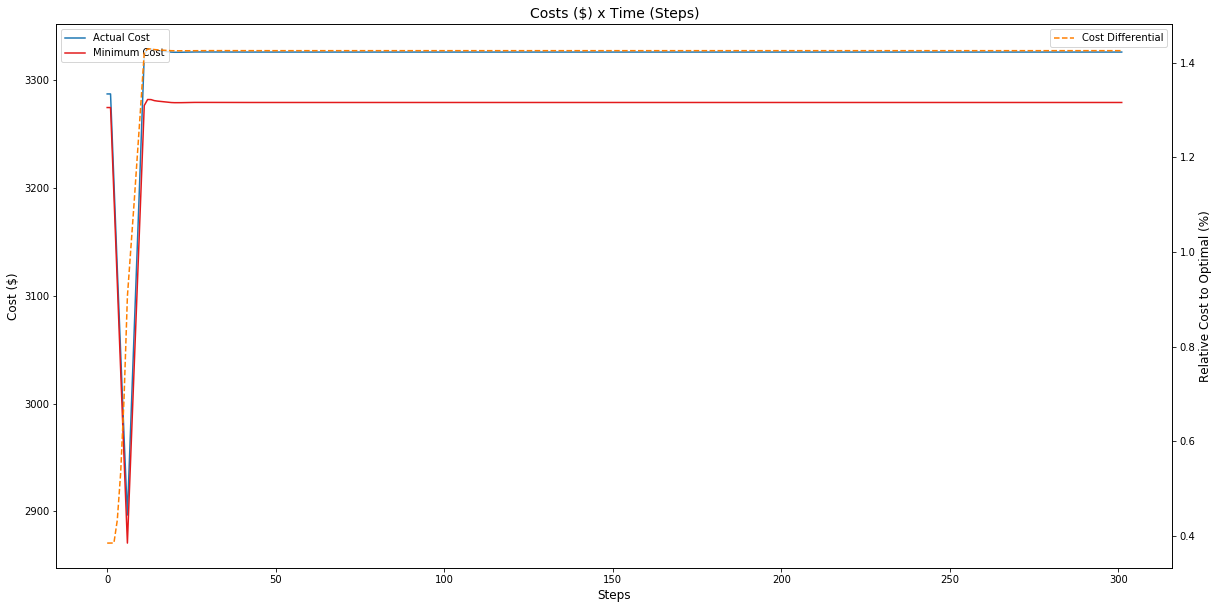

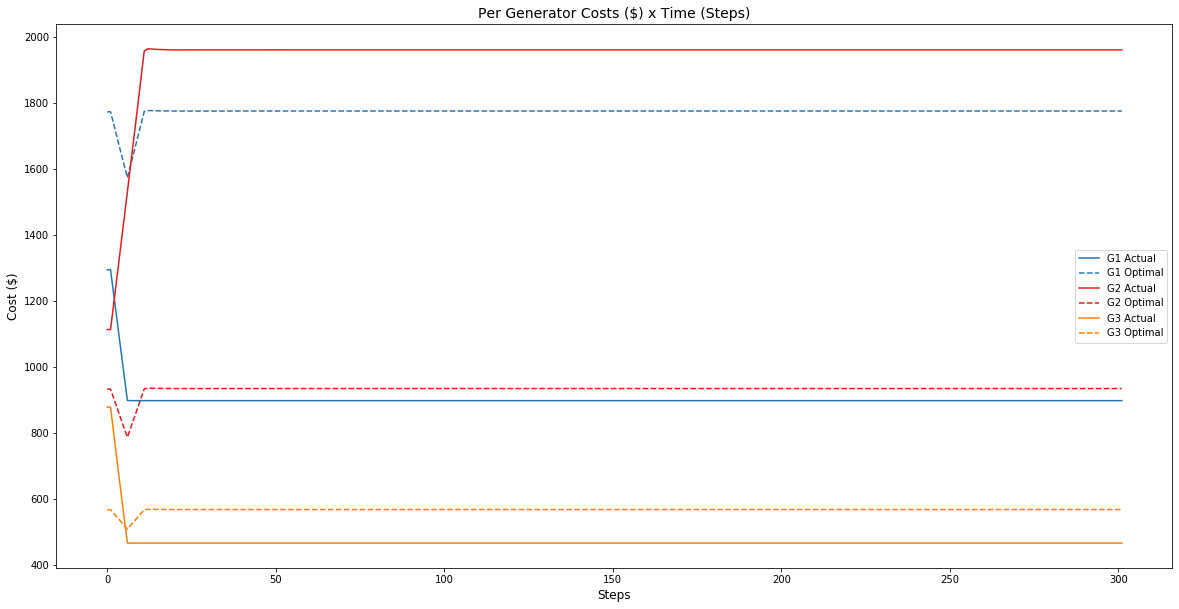

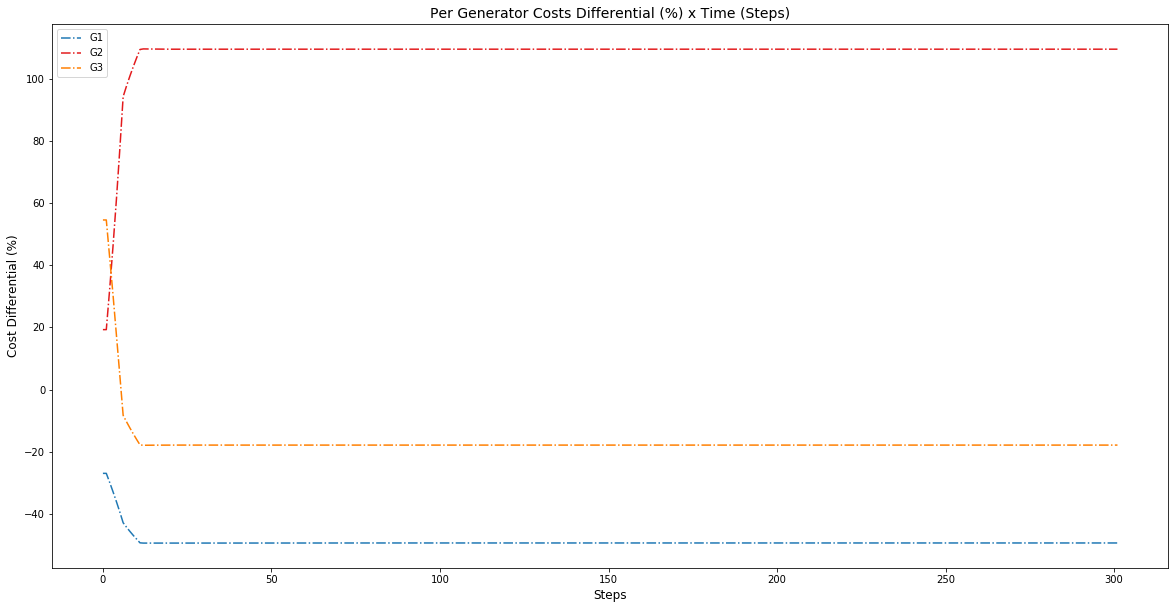

In [13]:
plotAll(electricalSystem.systemHistory)

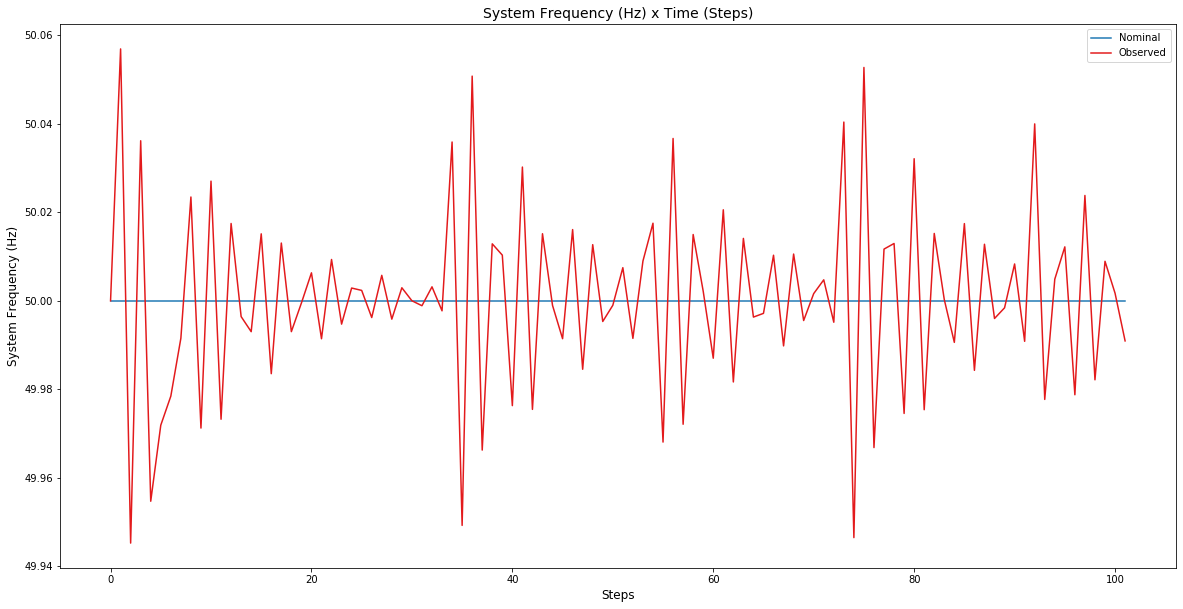

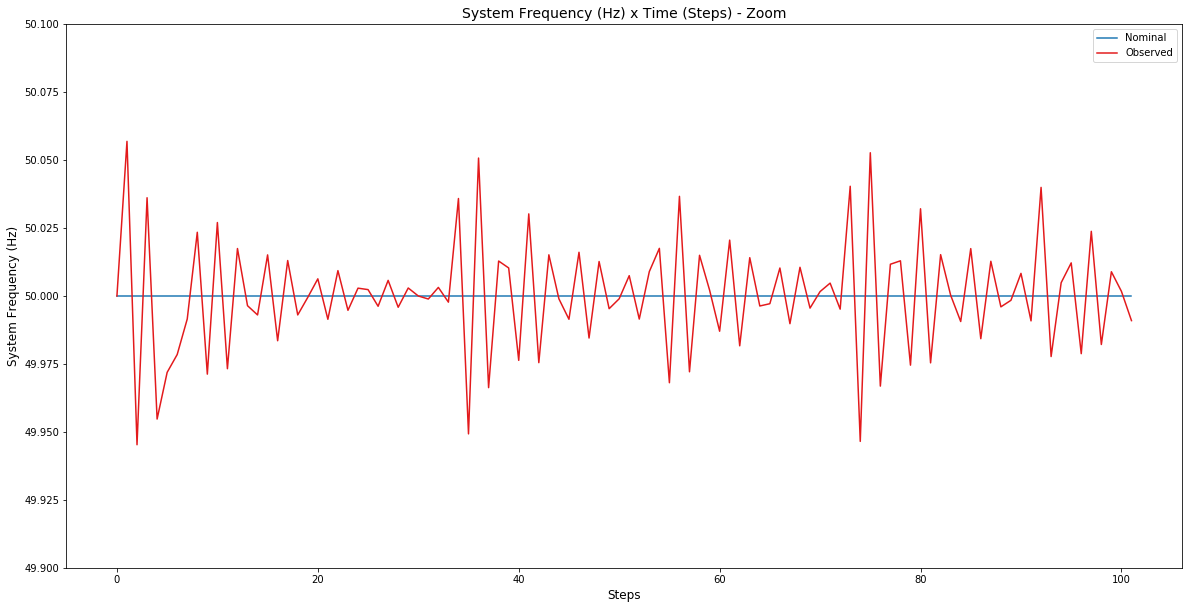

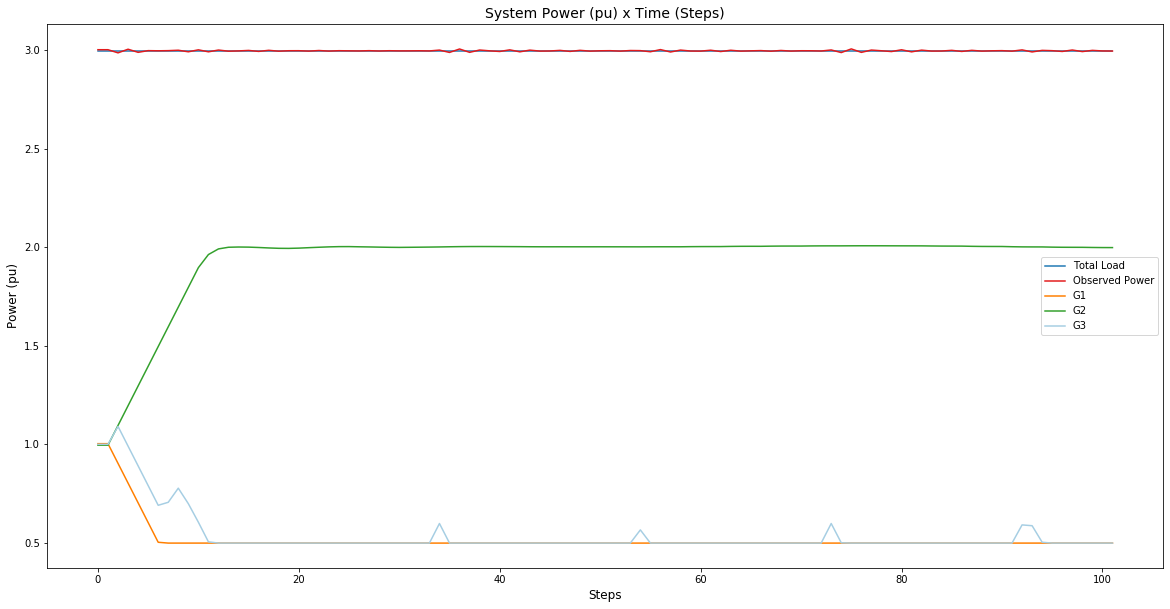

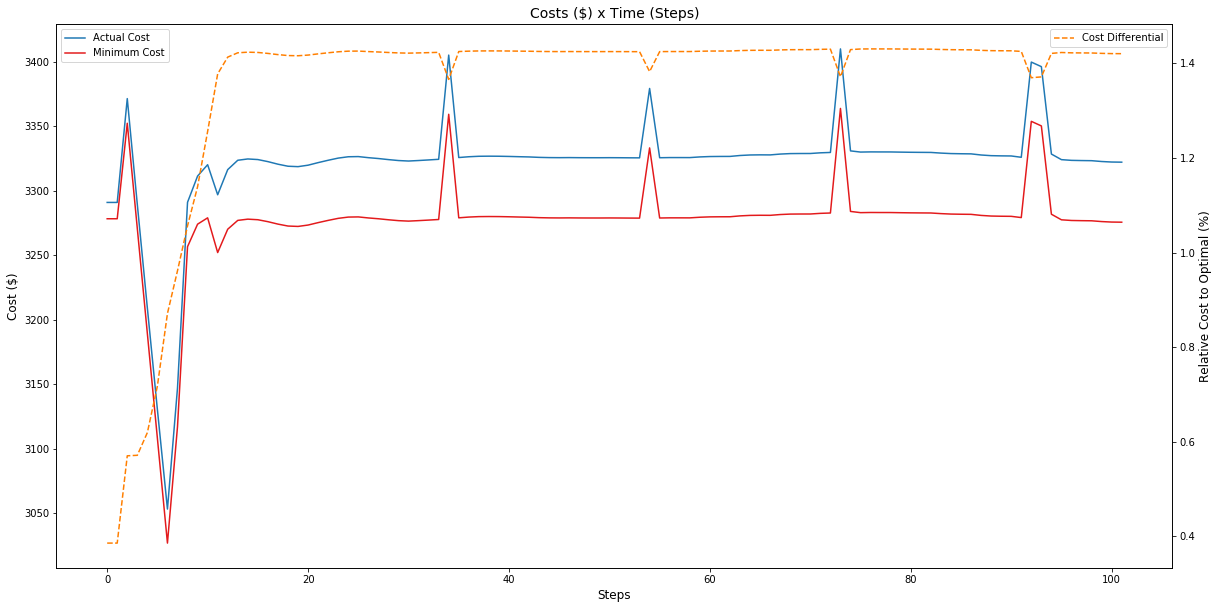

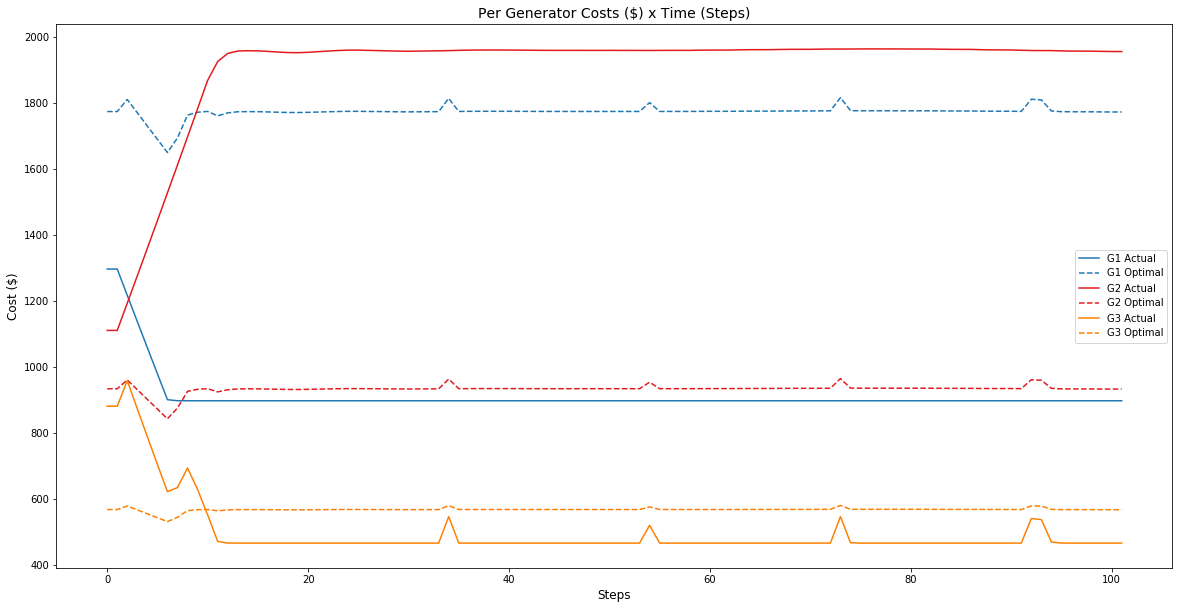

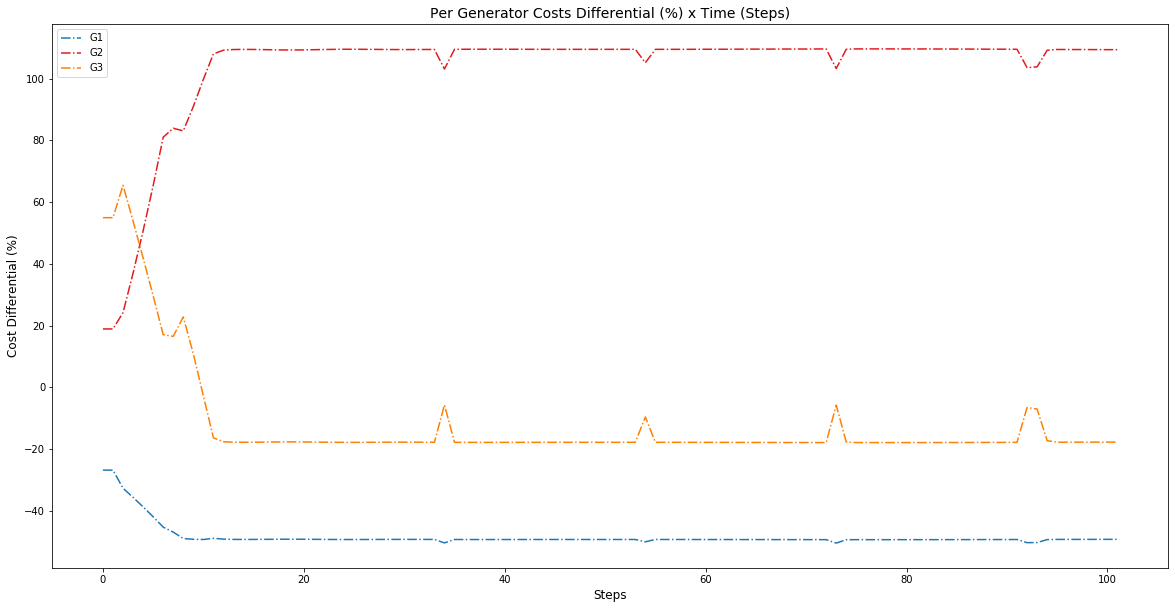

In [14]:
# # Show the last episode ran during training
from learning.learning_state import LearningState
plotAll(LearningState().episode.electricalSystem.systemHistory)

In [15]:
from learning.learning_state import LearningState
import numpy as np

rewList = LearningState().model.cummRewardList

In [16]:
LearningState().model.allRewards

[[{'cost': 0.9930599586385905,
   'output': 2.794463722309917e-16,
   'total': 2.775070028494128e-16},
  {'cost': 0.9716015359436588,
   'output': 0.17960256580220366,
   'total': 0.17450212879284313},
  {'cost': 0.9651299158424653,
   'output': 0.0002965967550649651,
   'total': 0.00028625440125499803},
  {'cost': 0.9818572487394024,
   'output': 0.08964095180147887,
   'total': 0.08801461831018141},
  {'cost': 0.9768245518945615,
   'output': 0.9877613509618137,
   'total': 0.9648695390320404},
  {'cost': 0.9847277620935586,
   'output': 0.00124029260098479,
   'total': 0.0012213505573089513},
  {'cost': 0.9464383457694345,
   'output': 6.916852134393084e-18,
   'total': 6.546374092006773e-18},
  {'cost': 0.9359550172669663,
   'output': 1.339155325315071e-26,
   'total': 1.253389145628417e-26},
  {'cost': 0.9077359389470914,
   'output': 1.723228579160944e-58,
   'total': 1.5642365123251216e-58},
  {'cost': 0.8605121828621718,
   'output': 1.188283187154749e-135,
   'total': 1.02253

TypeError: float() argument must be a string or a number, not 'dict'

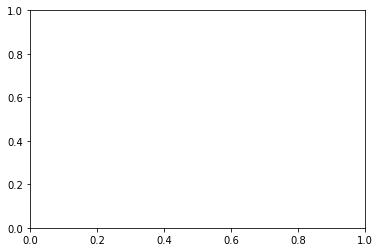

In [17]:
allRewards = LearningState().model.allRewards


for r in allRewards:
    plt.figure()
    plt.scatter(range(len(r)), r)
# sum(rewards)

In [ ]:
plt.scatter(range(len(rewList)), rewList)

In [ ]:
from plots.plot_constants import COLOR_PALETTE, FONT_SIZES

history = electricalSystem.systemHistory
# Get series to be plotted
stepsSeries = history.steps
loads = history.loads
totalLoadSeries = history.totalLoad
generators = history.generators
totalPowerSeries = history.totalPower

plt.figure(0)

# Declare colors to be used
colorTotalLoad = COLOR_PALETTE[0]
colorTotalPower = COLOR_PALETTE[1]
colorsIndividualNodes = COLOR_PALETTE[3:]

# Plot total power/load data
plt.plot(stepsSeries, totalLoadSeries, color=colorTotalLoad)
plt.plot(stepsSeries, totalPowerSeries, color=colorTotalPower)
legendFields = ['Total Load', 'Total Power']

# Multiple scenarios involve a single load, so we make it optional to plot that single load
if(False):
    for idx, loadId in enumerate(loads):
        # Since num loads is variable, colors may wrap around the palette
        loadColor = colorsIndividualNodes[idx % len(colorsIndividualNodes)]
        loadLegend = loadId
        loadSeries = loads[loadId]
        plt.plot(stepsSeries, loadSeries, color=loadColor, linestyle='--')
        legendFields.append(loadLegend)

for idx, generatorId in enumerate(generators):
    # Since num generators is variable, colors may wrap around the palette
    generatorColor = colorsIndividualNodes[idx % len(colorsIndividualNodes)]
    generatorLegend = generatorId
    generatorSeries = generators[generatorId]
    plt.plot(stepsSeries, generatorSeries, color=generatorColor)
    legendFields.append(generatorLegend)
    

summedPow = [x + y for x, y in zip(generators.get('G1'), generators.get('G2'))]
plt.plot(stepsSeries, summedPow, color=COLOR_PALETTE[2])
legendFields.append("Summed Pow")


plt.legend(legendFields)
plt.xlabel('Steps', fontsize=FONT_SIZES['AXIS_LABEL'])
plt.ylabel('Power (pu)', fontsize=FONT_SIZES['AXIS_LABEL'])

plt.title('System Power (pu) x Time (Steps)', fontsize=FONT_SIZES['TITLE'])

plt.show()